In [132]:
import numpy as np                                              # import numerical python
import matplotlib.pyplot as plt                                 # import plot library

# Scale Matters
A study into the 'fairness' of scaling large-scale assessments <br>
By: Gerard Barkema, Matthieu Brinkhuis & Berenice Michels

## Simulating a large-scale test
We simulate a test adminstered to *N* students, consisting of *M* items. <br>
The test is meant to measure a latent ability of the students $\theta$ which we assume to be random normally distributed around a mean value <$\theta$> with a standard deviation $\sigma_\theta$. 

> simulation: change N, M, <$\theta$>, $\sigma_\theta$

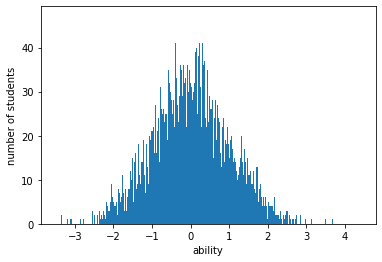

In [133]:
# CHOOSE: define population_length as array length for population (N) 
# CHOOSE: and test_length as array lenght for test (M)
population_length = 10000                                       #N
test_length = 100                                             #M

# CHOOSE mean and standard deviation for ability 
ability_mean = 0.0                                              # theta_mean
ability_stddev = 1.0                                            # sigma_theta

# fill ability array (if necessary with fixed seed)
give_seed=10051968

np.random.seed(give_seed)
#np.random.seed()
ability = np.random.normal(ability_mean,ability_stddev,population_length)
                                                                # array with random normally distributed abilities

#determine min and max ability for scaling and transformation 
#(DeMars: most examinees will have values between -3 and 3)
ability_min=ability_mean-3*ability_stddev
ability_max=ability_mean+3*ability_stddev

#keep the original abilityvector in ability_org
ability_org = ability.copy()
plt.hist(ability_org,bins=int(population_length/10))
plt.xlabel("ability")
plt.ylabel("number of students");    

We can choose to simulate a situation where part of the examinees gets 'better' (probably through extra education).<br>
In that case select: subsample = "True" <br> <br>
We divide the whole range of abilities in subsamples, defined by the distance to the mean.
The subsamples have a width of *n*$\sigma_\theta$, where *n* can be set. <br>
All abilities can be adjusted, or only part of the array, given by the number of items to take out of another (larger or same) number of items. <br>
The lower and upper border of the abilities that are to be corrected are given through edu_min and edu_max. Both will be multiplied with the width of the subsample and than added to the mean (so use negative numbers if you want to adjus the abilities below the mean.<br>
Finally, the effect of the extra education is represented by an amplification factor, relative to the standard deviation.
> simulation: sub (=width of subsample); take and out_of; edu_min and edu_max; amplif

In [134]:
subsample = False

# not included in this version of the model

Each item *i* has a difficulty $\beta_i$. In accordance with general Item Response Theory (e.g. DeMars, 2010) the difficulty identifies the ability at which 50% of the students, taking the test, is expected to give a correct answer to the question. $\theta$ and $\beta$ are defined on the same metric. 
We can set the mean and standard deviation of the difficulty of the items in the test in comparison to that of the student's ability: $\Delta_\theta$ and $\Delta_\sigma$.

In simulating the test, we assume that the probability *P* that student *i*  answers question *j*
correctly (and obtaines a score of 1), is given by the 1PL Item Response Function


$$
\\
\begin{equation}
P_{ij}=\frac{\exp(\alpha(\theta_i-\beta_j))}{1+\exp(\alpha(\theta_i-\beta_j))}
\end{equation}
%
$$

where $\alpha$ is a constant, denoting the discrimination of the items.


In [135]:
# define function IRF
def IRF(L,M,theta,beta,alfa):
#    L: integer - population size
#    M: integer - number of test items
#    theta: 2d-array of floats; shape (L,M) - abilities
#    beta = 2d-array of floats; shape (L,M) - difficulties
#    alfa = float - constant
    D = (theta - beta)*alfa
    IRF = np.exp(D)/(1+np.exp(D))
    return(IRF)

> simulation: 
* change Δ𝜃, Δ𝜎 and $\alpha$ <br>
* choose the distribution of de difficulties: normally random, uniformly random or uniformly
* number of iterations

In [136]:
# CHOOSE mean and standard deviation for difficulty (in relation to the ability values)
mean_dif = 0.0                                              # Delta_theta
stddev_dif = 1.0                                            # Delta_sigma
width = 4.0                                                 # for uniform distributions, set to 4*stddev of beta

# CHOOSE alpha
alpha = 20.0

# CHOOSE distribution of difficulties: 1 = normally random, 2 = uniformly random, 3 = uniformly
# set seed if wanted (seeding = TRUE)
distribution = 1
seeding = True

# CHOOSE number of iterations
sample = 1                                                   # number of iterations

Now we run the test. 
We simulate that the population of students with ability $\theta$ takes the test with difficulties $\beta$.

In [137]:
#fill empty arrays (necessary for sample >1)
test_score = np.zeros(population_length)
p_values = np.zeros(test_length)

# set the difficulty mean and stddev
difficulty_mean = ability_mean + mean_dif                       # calculated mean of difficulties
difficulty_stddev = ability_stddev + stddev_dif                 # calculated standard deviation of difficulties

# start loop through 'sample' iterations
for x in range(sample):
    if (distribution==1):
        if seeding:
            np.random.seed(give_seed)
        else: 
            np.random.seed()
        difficulty = np.random.normal(difficulty_mean, difficulty_stddev, test_length)                                                            
                                                        # array with random **normally** distributed difficulties
    elif (distribution==2):
        if seeding:
            np.random.seed(give_seed)
        else: 
            np.random.seed()
        difficulty = np.random.uniform(low=difficulty_mean-width,high=difficulty_mean+width,size=test_length)
                                                        # array with random **uniformly** distributed difficulties
    elif (distribution==3):
        difficulty = np.linspace(difficulty_mean-width,difficulty_mean+width,num=test_length,endpoint=True)
                                                        # array with linear **uniformly** distributed difficulties
    
#Calculate the probability of a correct score for every combination of student *i* and item *j*
    rs_ability = ability.reshape(population_length,1)
    rs_difficulty = difficulty.reshape(1,test_length)
    testresult=IRF(population_length,test_length,rs_ability,rs_difficulty,alpha)                   
                                       # NxM array with probabilities of correct responses of student *i* to item *j*

# Determine for every student - item combination whether the student answers the item correctly as follws:
# compare each probability P to a random generated probability R (uniform), 
# if P > R the item score = 1; if P <= R the item score = 0
    np.random.seed()
    rand_compare = np.random.uniform(low=0,high=1,size=(population_length,test_length))
    compare = np.greater(testresult,rand_compare)
    testresult = compare.astype(int)                               # NxM array with item results (0 or 1)
    
# Calculate the testscore per student based on the item being correct (=1) or incorrect (=0)
    test_score_x = np.sum(testresult,axis=1)
    test_score = test_score + test_score_x                                                              # N array with test-scores of students
    
# Calculate the CTT p-value per testitem based on the item being correct (=1) or incorrect (=0)
    p_values_x = np.mean(testresult,axis=0)        # M-array with p-values (difficulties) of items                    
    p_values = p_values + p_values_x
    
test_score = test_score/sample
p_values = p_values/sample

sorted_p_values = np.sort(p_values)
sorted_p_values_x = np.sort(p_values_x)

test_mean = np.mean(test_score)
test_std = np.std(test_score)

In [138]:
# scale the results - linear transformation
# measured abilities (between 0 and 1)
scale_min = ability_min
scale_max = ability_max

scale_length = scale_max - scale_min

#Scale: measured ability as linear transformation from test_score
meas_ability = (test_score/test_length)*scale_length + scale_min
meas_ab_mean = np.mean(meas_ability)
meas_ab_std = np.std(meas_ability)

# other scaling
scale_min = 0
scale_max = 10

scale_length = scale_max - scale_min

scaled_score = (test_score/test_length)*scale_length + scale_min
scaled_mean = np.mean(scaled_score)
scaled_std = np.std(scaled_score)

In [139]:
#Calculate the mean squared distance between the original ability and the measured ability
ability_error=np.mean(np.square(ability_org-meas_ability))

N = 10000   M = 100
mean ability = 0.0    standdard deviation ability = 1.00
mean difficulty = 0.0   standdard deviation difficulty = 2.00
distribution difficulty : 1
discrimination = 20.0, number of samples: 1

mean score = 45.70  standard deviation = 17.61
mean scaled score = 4.57  standard deviation scaled = 1.76
mean measured ability = -0.26   standard deviation measured ability = 1.06
ability error = 0.0914


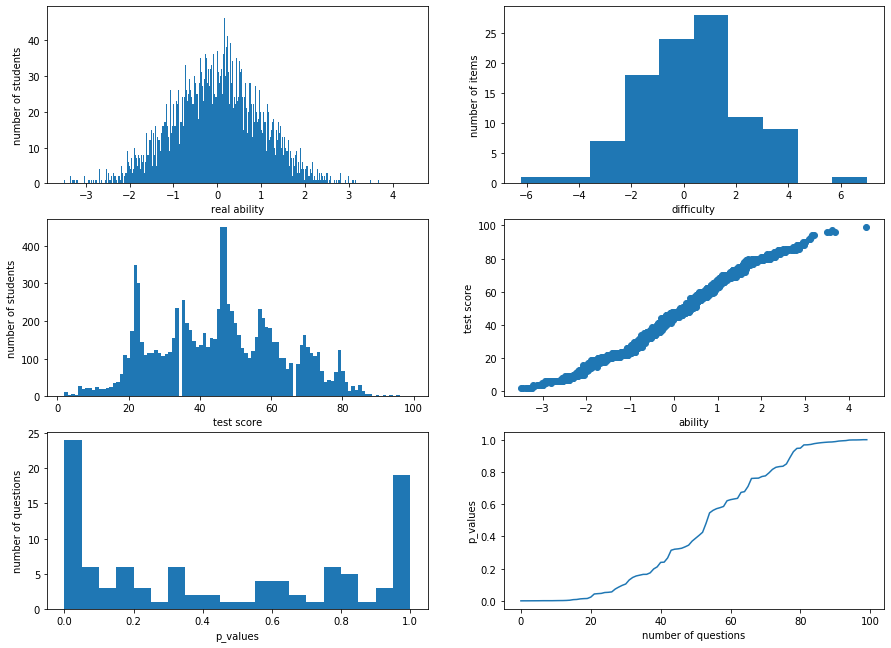

In [140]:
#Print output

plt.figure(figsize=(15,15))

plt.subplot(421)
plt.hist(ability,bins=int(population_length/10))
plt.xlabel("real ability")
plt.ylabel("number of students");

plt.subplot(422)
plt.hist(difficulty, bins=int(test_length/10))
plt.xlabel("difficulty")
plt.ylabel("number of items");

plt.subplot(423)
plt.hist(test_score,bins=int(test_length))
plt.xlabel("test score")
plt.ylabel("number of students");

plt.subplot(424)
plt.scatter(ability,test_score)
plt.xlabel("ability")
plt.ylabel("test score");

plt.subplot(425)
plt.hist(p_values,bins=20,range=(0,1))
plt.xlabel("p_values")
plt.ylabel("number of questions");

plt.subplot(426)
plt.plot(sorted_p_values)
plt.xlabel("number of questions")
plt.ylabel("p_values");

print("N = %.i   M = %.i"%(population_length,test_length))
print("mean ability = %.1f    standdard deviation ability = %.2f"%(ability_mean,ability_stddev))
print("mean difficulty = %.1f   standdard deviation difficulty = %.2f"%(difficulty_mean,difficulty_stddev))
print("distribution difficulty : %.i"%(distribution))
if distribution != 1:
    print("width distribution difficulty = %.1f"%(width))
print("discrimination = %.1f, number of samples: %.i"%(alpha,sample))
print()
print("mean score = %.2f  standard deviation = %.2f"%(test_mean,test_std))
print("mean scaled score = %.2f  standard deviation scaled = %.2f"%(scaled_mean,scaled_std))
print("mean measured ability = %.2f   standard deviation measured ability = %.2f"%(meas_ab_mean,meas_ab_std))
print("ability error = %.4f"%(ability_error))